/tmp/ipython-input-2903955423.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


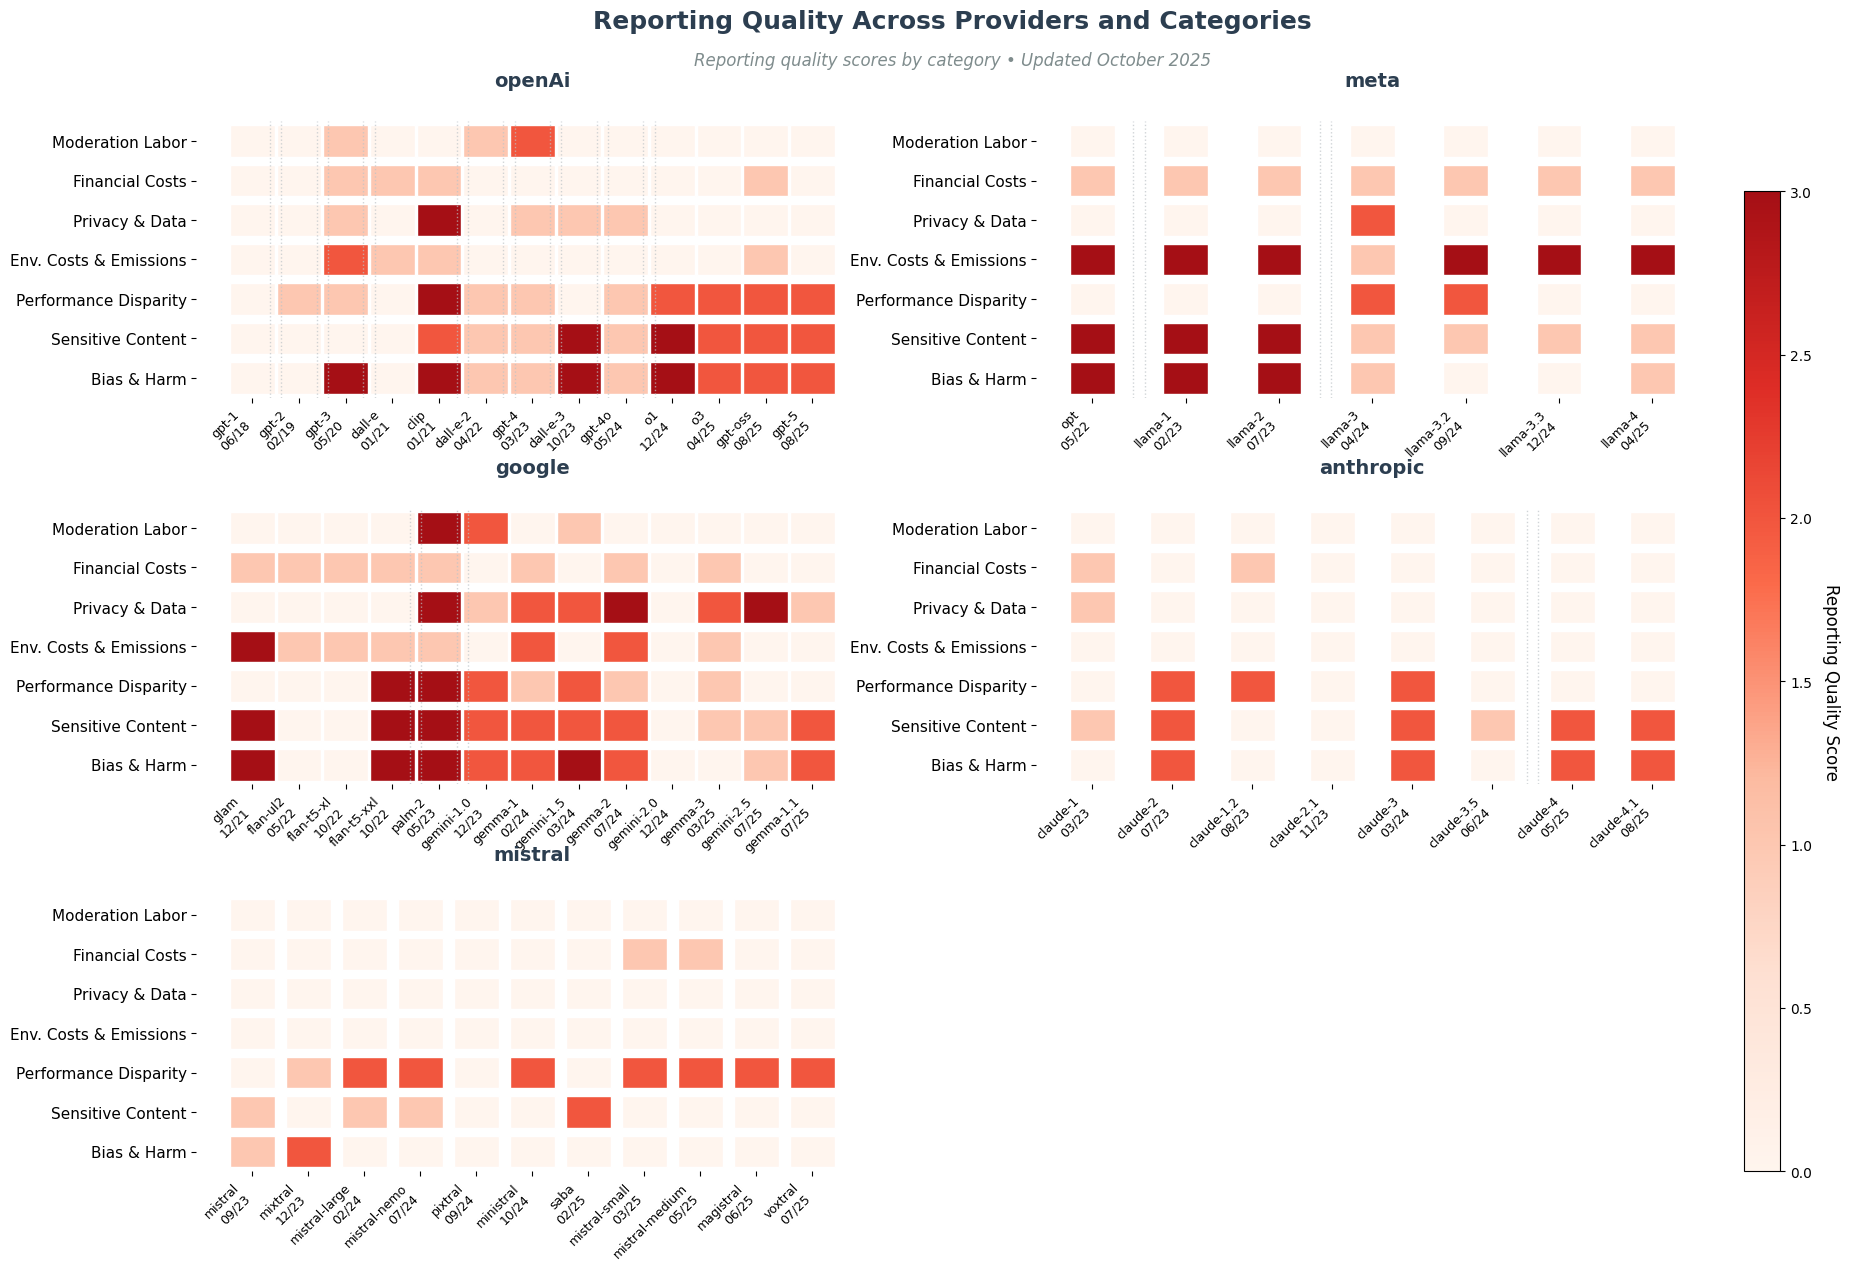

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Load and prepare data
df = pd.read_csv("datafile.tsv", sep="\t")

# Category mapping shorthands
category_mapping = {
    1: "Bias & Harm",
    2: "Sensitive Content",
    3: "Performance Disparity",
    4: "Env. Costs & Emissions",
    5: "Privacy & Data",
    6: "Financial Costs",
    7: "Moderation Labor"
}
# CATEGORY_SHORT = {
#     1: "BIA",
#     2: "CUL",
#     3: "DISP",
#     4: "ENV",
#     5: "PRIV",
#     6: "COST",
#     7: "MOD"
# }
df['category'] = df['category'].map(category_mapping)

# Filter for model releases only
df = df[df.is_model_release == True].copy()

# Parse timestamps from metadata
df['timestamp'] = pd.to_datetime(
    df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
)

# Sort by release date
df = df.sort_values('timestamp')

# Selected providers to plot
selected_providers = [
    'openAi',
    'meta',
    'google',
    'anthropic',
    'mistral'
]

# Custom colormap
colors_first = ['#FFF5EE', '#FEE0D2', '#FCBBA1', '#FB6A4A', '#DE2D26', '#A50F15']
cmap = LinearSegmentedColormap.from_list('orange_red_gradient', colors_first, N=256)

# Create the figure layout
fig = plt.figure(figsize=(18, 14))
fig.patch.set_facecolor('white')  # White background

gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.25,
                      left=0.08, right=0.92, top=0.85, bottom=0.1)

all_categories = list(category_mapping.values())

for idx, selected_provider in enumerate(selected_providers):
    row = idx // 2
    col = idx % 2
    if row >= 3:
        break

    ax = fig.add_subplot(gs[row, col])
    ax.set_facecolor('white')  # White subplot background

    # Filter data for provider
    curr_df = df[df.provider == selected_provider].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data for {selected_provider}',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{selected_provider}', fontsize=14, fontweight='bold', pad=25)
        continue

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    # Extract model information and calculate positions for equal subplot width
    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        model_labels.append(f"{row['name']}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Calculate positions to spread models evenly across a fixed width
    # All providers will span the same visual width (0 to STANDARD_WIDTH)
    STANDARD_WIDTH = 10  # Fixed width for all provider subplots
    if len(model_names) > 1:
        model_positions = np.linspace(0, STANDARD_WIDTH, len(model_names))
    else:
        model_positions = [STANDARD_WIDTH / 2]  # Center single model

    # Create complete combinations for all categories and models
    complete_combinations = []
    for model in model_names:
        for category in all_categories:
            complete_combinations.append({
                'name': model,
                'category': category
            })

    complete_df = pd.DataFrame(complete_combinations)

    # Merge with actual data
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    )

    # Fill missing categories with 0
    merged_df['score'] = merged_df['score'].fillna(0)

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category',
        columns='name',
        values='score',
        aggfunc='mean'
    )

    heatmap_data = heatmap_data.reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using scatter plot approach for custom positioning
    # First, create a background grid
    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)  # Normalize to 0-1 for colormap

            # Draw rectangle at custom position
            rect = plt.Rectangle((model_positions[j] - 0.4, i - 0.4), 0.8, 0.8,
                               facecolor=color, edgecolor='white', linewidth=1)
            ax.add_patch(rect)

    # Set up x-axis with custom positions
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)

    # Y-axis setup
    ax.set_yticks(range(len(all_categories)))
    ax.set_yticklabels(all_categories, fontsize=11)

    ###############

    # Add visual time gap indicators between models where there are large gaps
    if len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44

            # Add a subtle visual indicator for gaps > 6 months
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                # Add gap indicator lines
                ax.axvline(x=gap_x-0.1, color='#bdc3c7', linewidth=1, alpha=0.7, linestyle=':')
                ax.axvline(x=gap_x+0.1, color='#bdc3c7', linewidth=1, alpha=0.7, linestyle=':')

    ###############

    # Set axis limits to use the standard width for all providers
    ax.set_xlim(-1, STANDARD_WIDTH + 1)
    ax.set_ylim(-0.5, len(all_categories) - 0.5)

    # Remove automatic grid lines since we're using custom positioning
    ax.grid(False)

    # Style
    ax.set_title(f'{selected_provider}', fontsize=14, fontweight='bold',
                 pad=25, color='#2c3e50')
    for spine in ax.spines.values():
        spine.set_visible(False)

# Add shared colorbar
norm = Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.94, 0.1, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Reporting Quality Score',
               rotation=270, labelpad=20, fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Titles
fig.suptitle('Reporting Quality Across Providers and Categories',
             fontsize=18, fontweight='bold', y=0.93, color='#2c3e50')

current_date = datetime.now().strftime("%B %Y")
fig.text(0.5, 0.89,
         f'Reporting quality scores by category • Updated {current_date}',
         ha='center', fontsize=12, style='italic', color='#7f8c8d')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_provider_reporting_quality(provider_name, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(9, 7), show_time_gaps=False, show_values=False, show_colorbar=True):
    """
    Generate a reporting quality heatmap for a single provider.

    Parameters:
    -----------
    provider_name : str
        Name of the provider to plot (e.g., 'openAi', 'meta', 'google', 'anthropic', 'mistral')
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping
    category_mapping = {
        1: "Bias & Harm",
        2: "Sensitive Content",
        3: "Performance Disparity",
        4: "Env. Costs & Emissions",
        5: "Privacy & Data",
        6: "Financial Costs",
        7: "Moderation Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Custom colormap
    colors_first = ['#FFF5EE', '#FEE0D2', '#FCBBA1', '#FB6A4A', '#DE2D26', '#A50F15']
    cmap = LinearSegmentedColormap.from_list('orange_red_gradient', colors_first, N=256)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    all_categories = list(category_mapping.values())

    # Filter data for the specified provider
    curr_df = df[df.provider == provider_name].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{provider_name}', fontsize=16, fontweight='bold', pad=25)
        return fig, ax

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    # Extract model information
    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        # Capitalize first letter of model name
        formatted_name = row['name'].capitalize()
        model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Calculate positions to spread models evenly across a fixed width
    # All providers will span the same visual width (0 to STANDARD_WIDTH)
    STANDARD_WIDTH = 10  # Fixed width for all provider subplots
    if len(model_names) > 1:
        model_positions = np.linspace(0, STANDARD_WIDTH, len(model_names))
    else:
        model_positions = [STANDARD_WIDTH / 2]  # Center single model

    # Create complete combinations for all categories and models
    complete_combinations = []
    for model in model_names:
        for category in all_categories:
            complete_combinations.append({
                'name': model,
                'category': category
            })

    complete_df = pd.DataFrame(complete_combinations)

    # Merge with actual data
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    )

    # Fill missing categories with 0
    merged_df['score'] = merged_df['score'].fillna(0)

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category',
        columns='name',
        values='score',
        aggfunc='mean'
    )

    heatmap_data = heatmap_data.reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using rectangles for custom positioning
    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)  # Normalize to 0-1 for colormap

            # Draw rectangle at custom position
            rect = plt.Rectangle((model_positions[j] - 0.4, i - 0.4), 0.8, 0.8,
                               facecolor=color, edgecolor='white', linewidth=1)
            ax.add_patch(rect)

            # Add text value if requested
            if show_values:  # Show all values including zeros
                # Choose text color based on background brightness
                text_color = 'white' if score > 1.5 else 'black'
                ax.text(model_positions[j], i, f'{score:.1f}',
                       ha='center', va='center', fontsize=10,
                       fontweight='bold', color=text_color)

    # Set up x-axis with custom positions
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=11)

    # Y-axis setup
    ax.set_yticks(range(len(all_categories)))
    ax.set_yticklabels(all_categories, fontsize=12)

    # Add visual time gap indicators if requested
    if show_time_gaps and len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44

            # Add a subtle visual indicator for gaps > 6 months
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                # Add gap indicator lines
                ax.axvline(x=gap_x-0.1, color='#bdc3c7', linewidth=1, alpha=0.7, linestyle=':')
                ax.axvline(x=gap_x+0.1, color='#bdc3c7', linewidth=1, alpha=0.7, linestyle=':')

    # Set axis limits
    ax.set_xlim(-1, STANDARD_WIDTH + 1)
    ax.set_ylim(-0.5, len(all_categories) - 0.5)

    # Remove grid and spines
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add colorbar if requested
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=20, fontsize=12)
        cbar.ax.tick_params(labelsize=10)

    # Titles
    ax.set_title(f'{provider_name.capitalize()}',
                 fontsize=16, fontweight='bold', pad=25, color='#2c3e50')

    # current_date = datetime.now().strftime("%B %Y")
    # fig.text(0.5, 0.02, f'Reporting quality scores by category • Updated {current_date}',
    #          ha='center', fontsize=10, style='italic', color='#7f8c8d')

    plt.tight_layout()
    return fig, ax

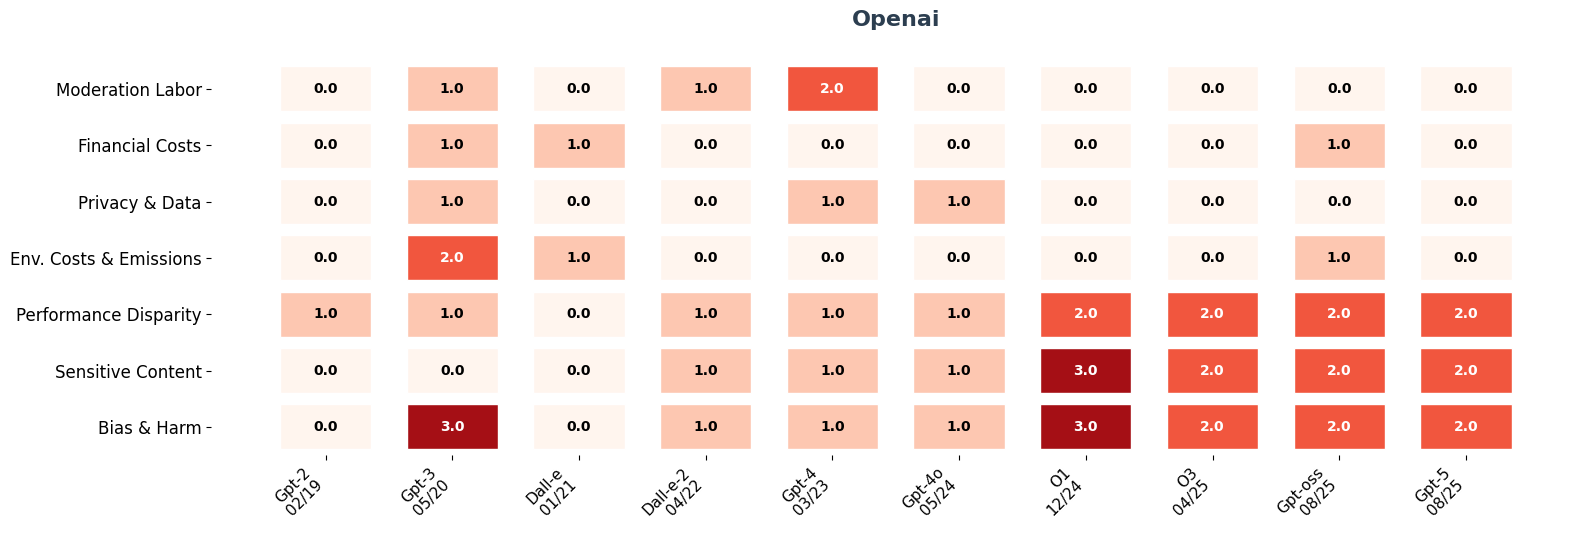

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plot_provider_reporting_quality('openAi', figsize=(16, 5.5),show_values=True, show_colorbar=False)
plt.show()
plt.savefig('openai_1p_overtime.pdf')

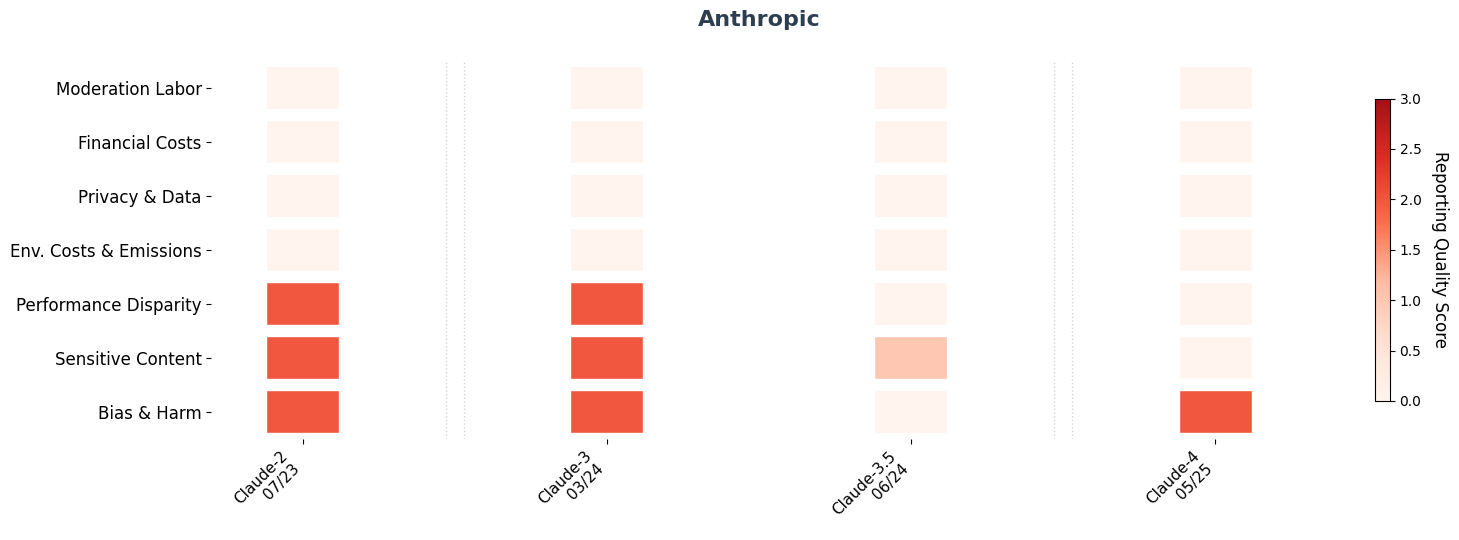

In [ ]:
fig, ax = plot_provider_reporting_quality('anthropic', figsize=(16, 5.5), show_time_gaps=True)
plt.show()

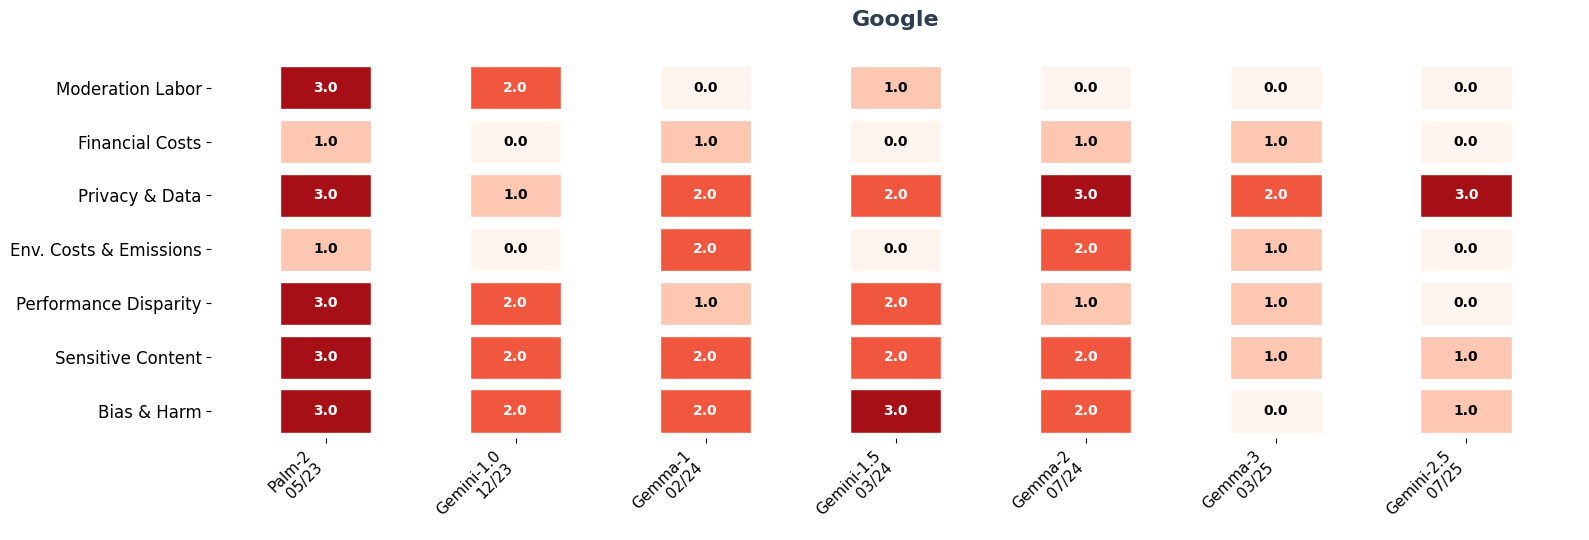

In [ ]:
fig, ax = plot_provider_reporting_quality('google', figsize=(16, 5.5), show_values=True, show_colorbar=False)
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

def plot_provider_reporting_quality(provider_name, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(9, 7), show_time_gaps=False, show_values=False, show_colorbar=True):
    """
    Generate a reporting quality heatmap for a single provider.

    Parameters:
    -----------
    provider_name : str
        Name of the provider to plot (e.g., 'openAi', 'meta', 'google', 'anthropic', 'mistral')
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # --- Font Setup ---
    # Download and register Times New Roman (regular, bold, and italic)
    font_files_to_download = {
        'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
        'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
        'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
    }

    # Create a directory for fonts if it doesn't exist
    font_dir = '/content/fonts'
    os.makedirs(font_dir, exist_ok=True)

    for fname, url in font_files_to_download.items():
        font_path = os.path.join(font_dir, fname)
        if not os.path.exists(font_path):
            subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

    # Register fonts with matplotlib
    for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
        fm.fontManager.addfont(font_path)

    # --- Matplotlib Style Configuration ---
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "font.size": 11,
        "axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 11,
        "ytick.labelsize": 11, "legend.fontsize": 16,
        "axes.spines.top": False, "axes.spines.left": False,
        "axes.spines.right": False, "axes.spines.bottom": False,
        "axes.titlepad": 6, "font.family": "Times New Roman",
        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",
    })

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping
    category_mapping = {
        1: "Bias & Harm", 2: "Sensitive Content", 3: "Performance Disparity",
        4: "Env. Costs & Emissions", 5: "Privacy & Data", 6: "Financial Costs",
        7: "Moderation Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Custom colormap from the first script
    colors_first = ['#FFF5EE', '#FEE0D2', '#FCBBA1', '#FB6A4A', '#DE2D26', '#A50F15']
    cmap = LinearSegmentedColormap.from_list('orange_red_gradient', colors_first, N=256)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    all_categories = list(category_mapping.values())

    # Filter data for the specified provider
    curr_df = df[df.provider == provider_name].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{provider_name}', fontsize=16, fontweight='bold', pad=25)
        return fig, ax

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        formatted_name = row['name'].capitalize()
        model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Using a fixed width for consistent visual spacing
    STANDARD_WIDTH = 10
    model_positions = np.linspace(0, STANDARD_WIDTH, len(model_names)) if len(model_names) > 1 else [STANDARD_WIDTH / 2]

    # Create complete combinations for all categories and models
    complete_df = pd.DataFrame([
        {'name': model, 'category': category}
        for model in model_names
        for category in all_categories
    ])

    # Merge with actual data and fill missing scores with 0
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    ).fillna({'score': 0})

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category', columns='name', values='score', aggfunc='mean'
    ).reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using rectangles
    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)

            rect = plt.Rectangle((model_positions[j] - 0.4, i - 0.4), 0.8, 0.8,
                               facecolor=color, edgecolor='white', linewidth=1)
            ax.add_patch(rect)

            if show_values:
                text_color = 'white' if score > 1.5 else 'black'
                ax.text(model_positions[j], i, f'{score:.1f}',
                       ha='center', va='center', fontsize=9,
                       fontweight='bold', color=text_color)

    # --- Axis and Label Formatting ---
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=11, fontweight='bold')

    ax.set_yticks(range(len(all_categories)))
    wrapped_labels = [textwrap.fill(label, width=15) for label in all_categories]
    ax.set_yticklabels(wrapped_labels, fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both', length=0)

    # Add time gap indicators if requested
    if show_time_gaps and len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                ax.axvline(x=gap_x, color='#bdc3c7', linewidth=1.5, linestyle=':')

    # Set axis limits and remove grid
    ax.set_xlim(-1, STANDARD_WIDTH + 1)
    ax.set_ylim(-0.5, len(all_categories) - 0.5)
    ax.grid(False)

    # Add colorbar if requested
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20, pad=0.03)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        cbar.outline.set_visible(False)

    # Titles
    ax.set_title(f'{provider_name.capitalize()}',
                 fontsize=20, fontweight='bold', pad=25, color='#2c3e50')

    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to prevent labels from being cut off

    return fig, ax

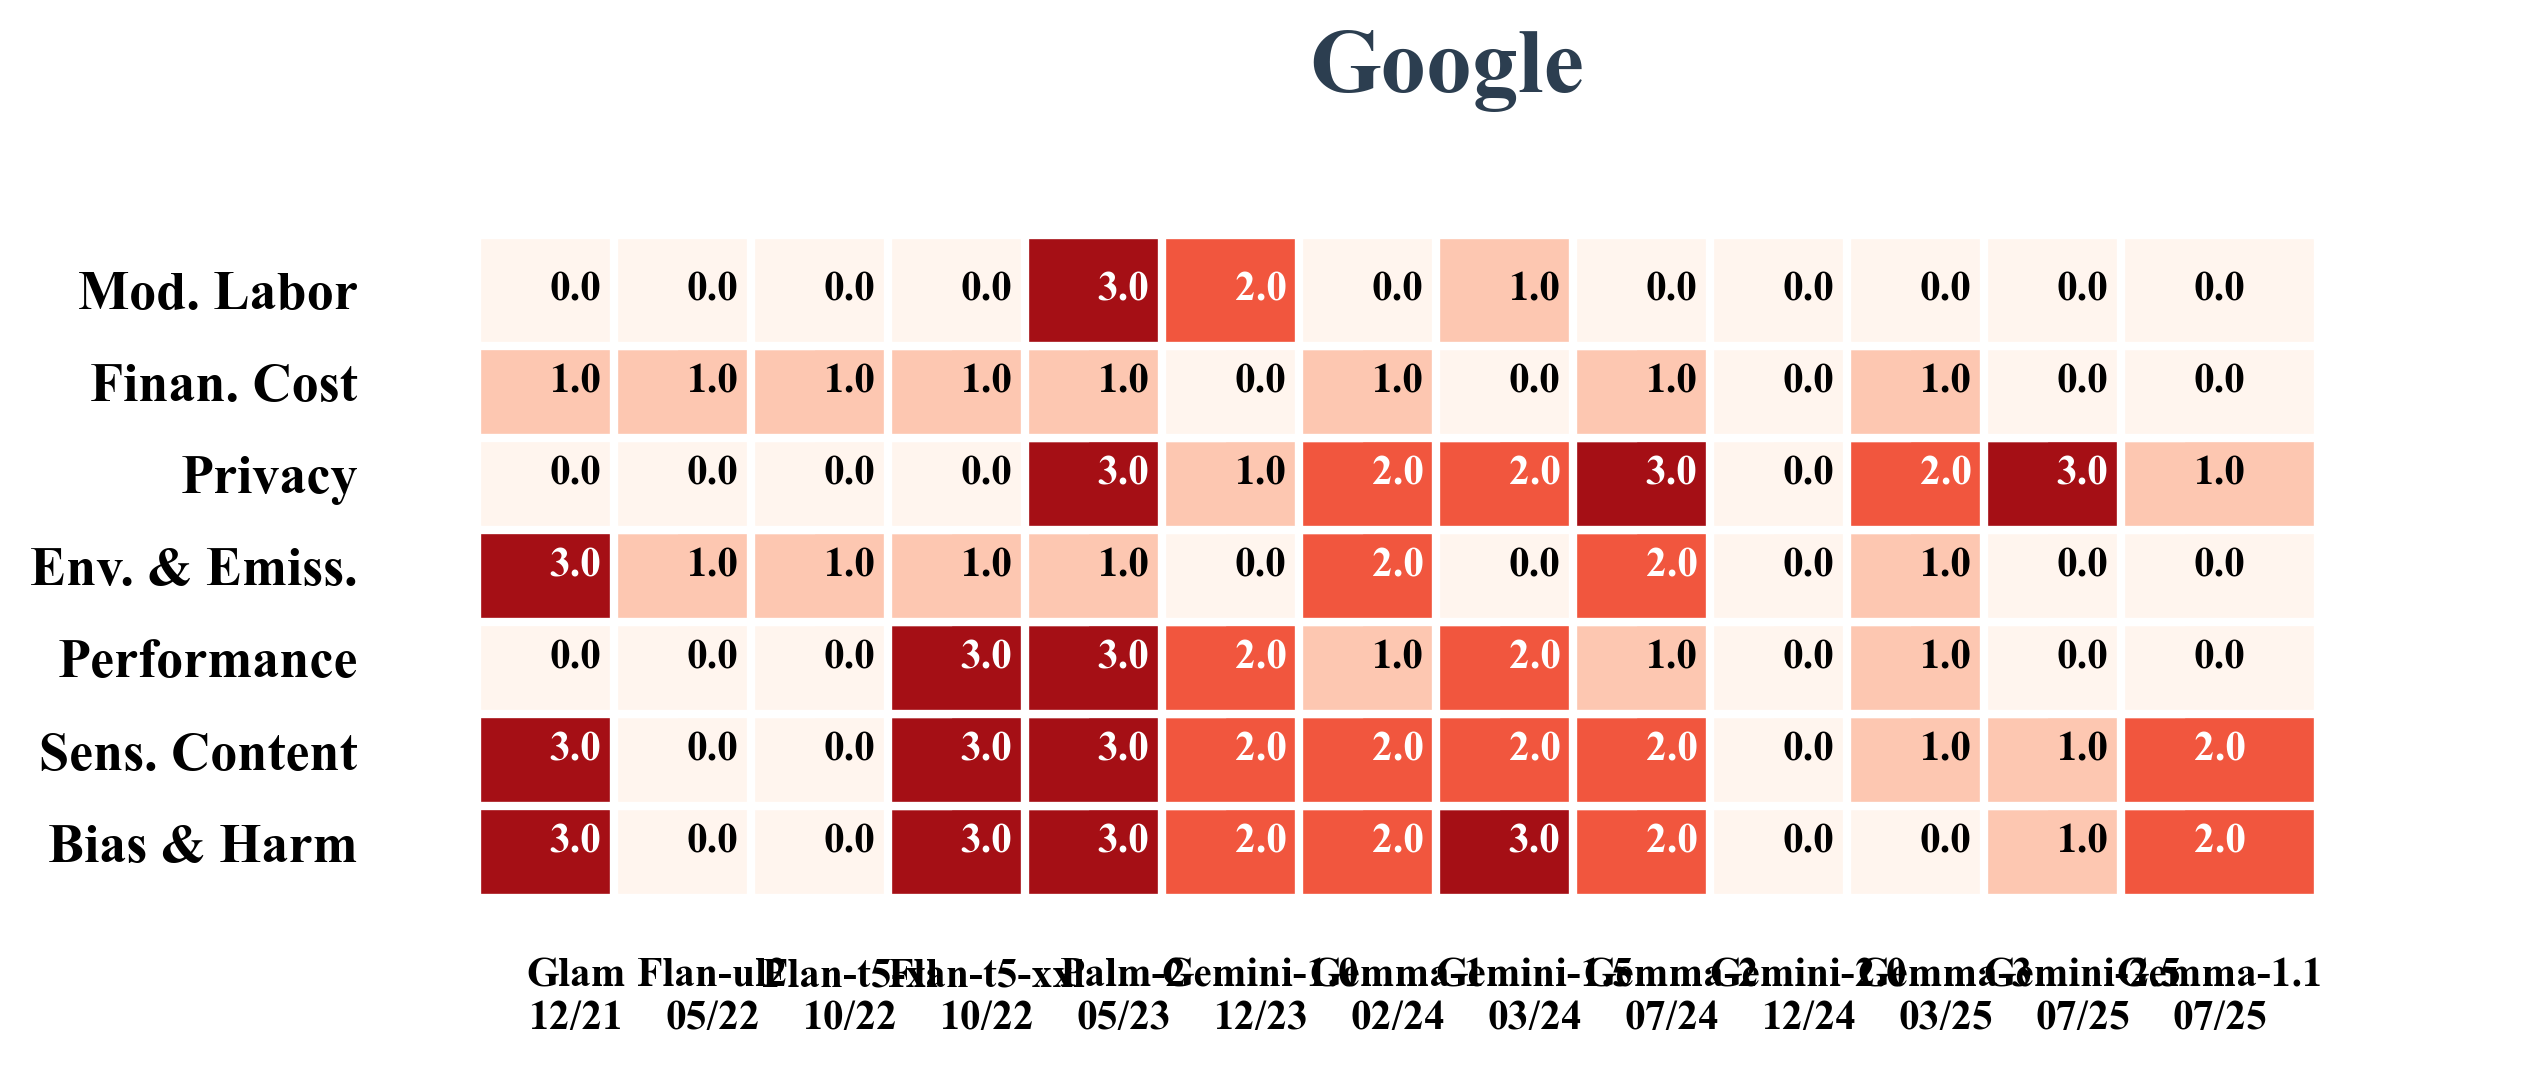

In [ ]:
fig, ax = plot_provider_reporting_quality('google', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('google_1p_overtime_adjusted.pdf')
plt.show()

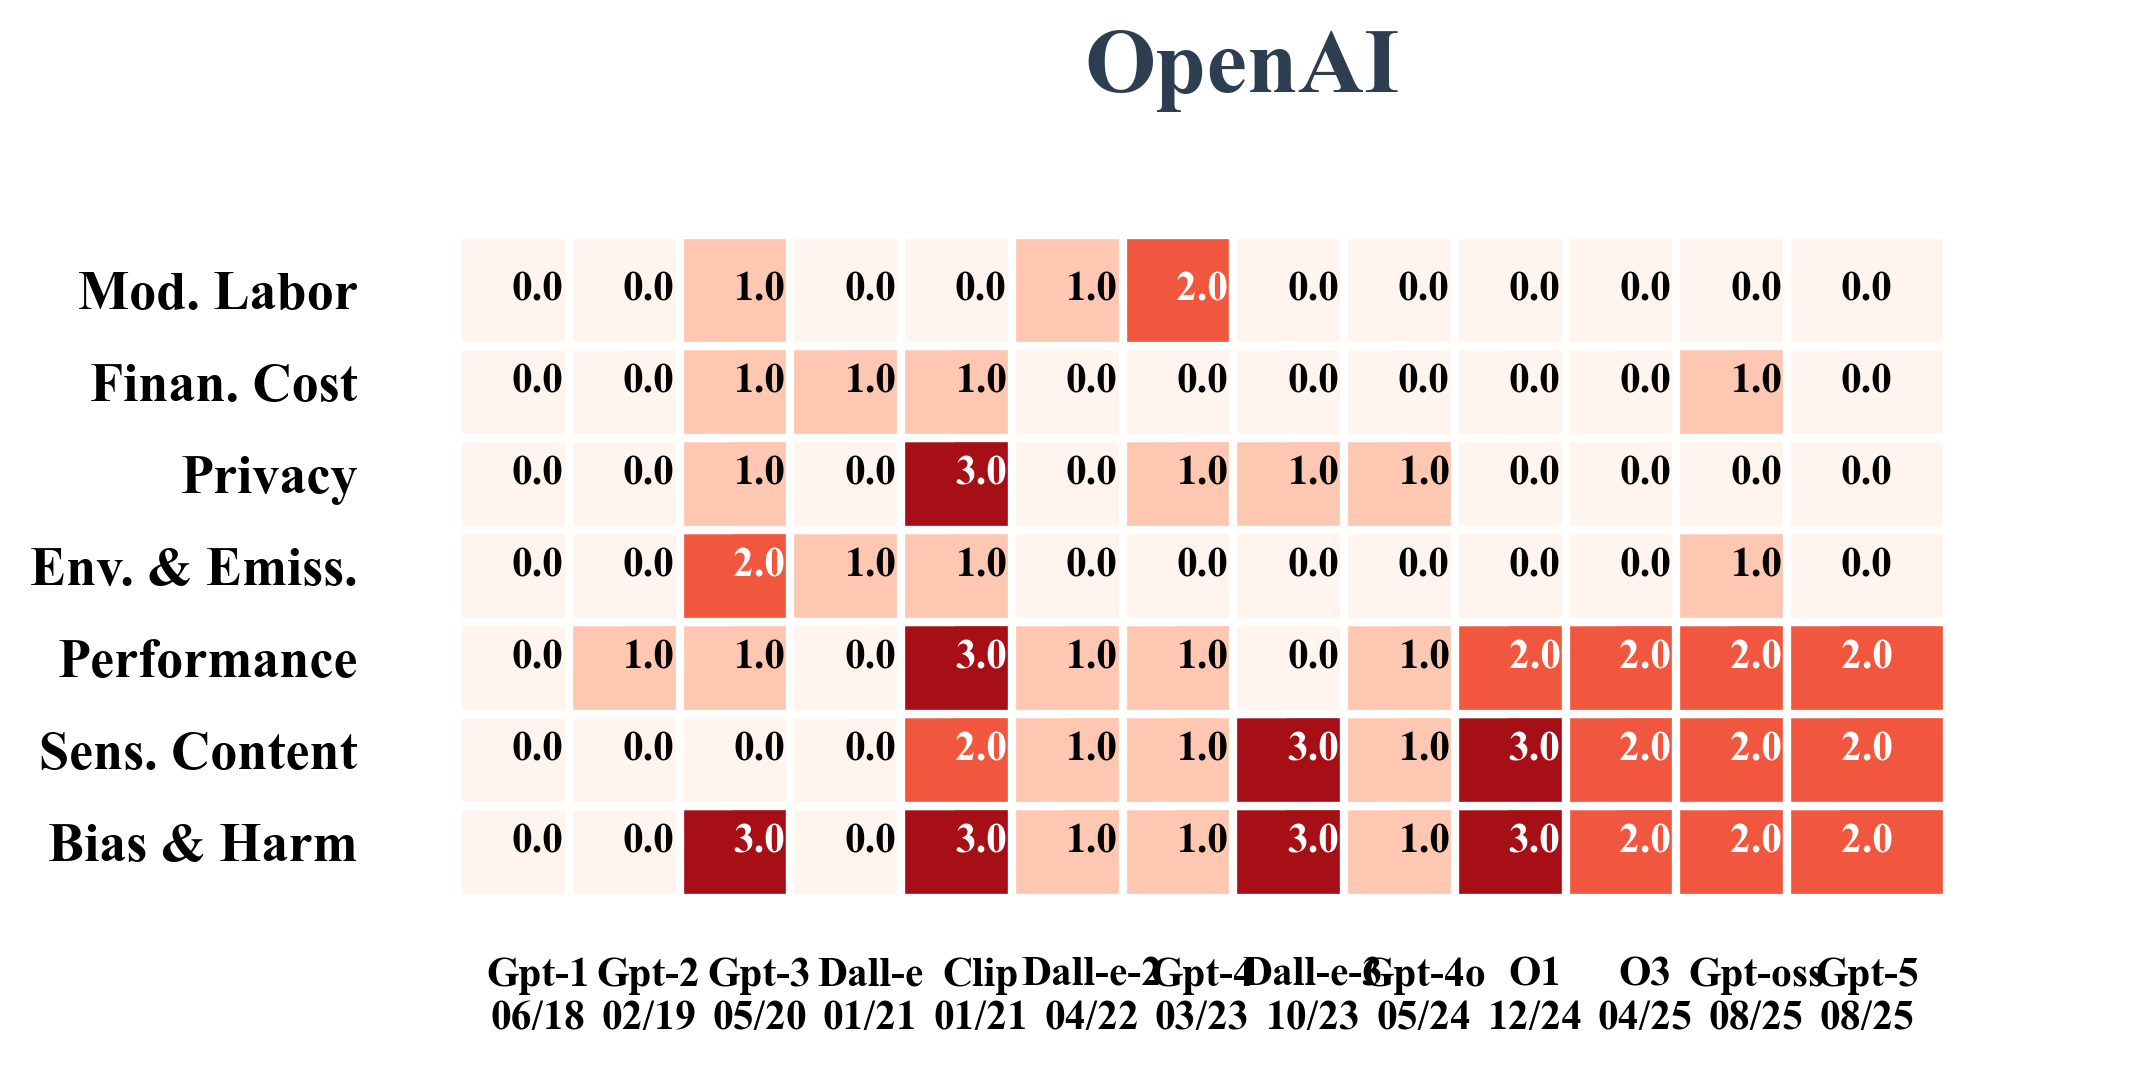

In [ ]:
fig, ax = plot_provider_reporting_quality('openAi', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('openai_1p_overtime_adjusted.pdf')
plt.show()

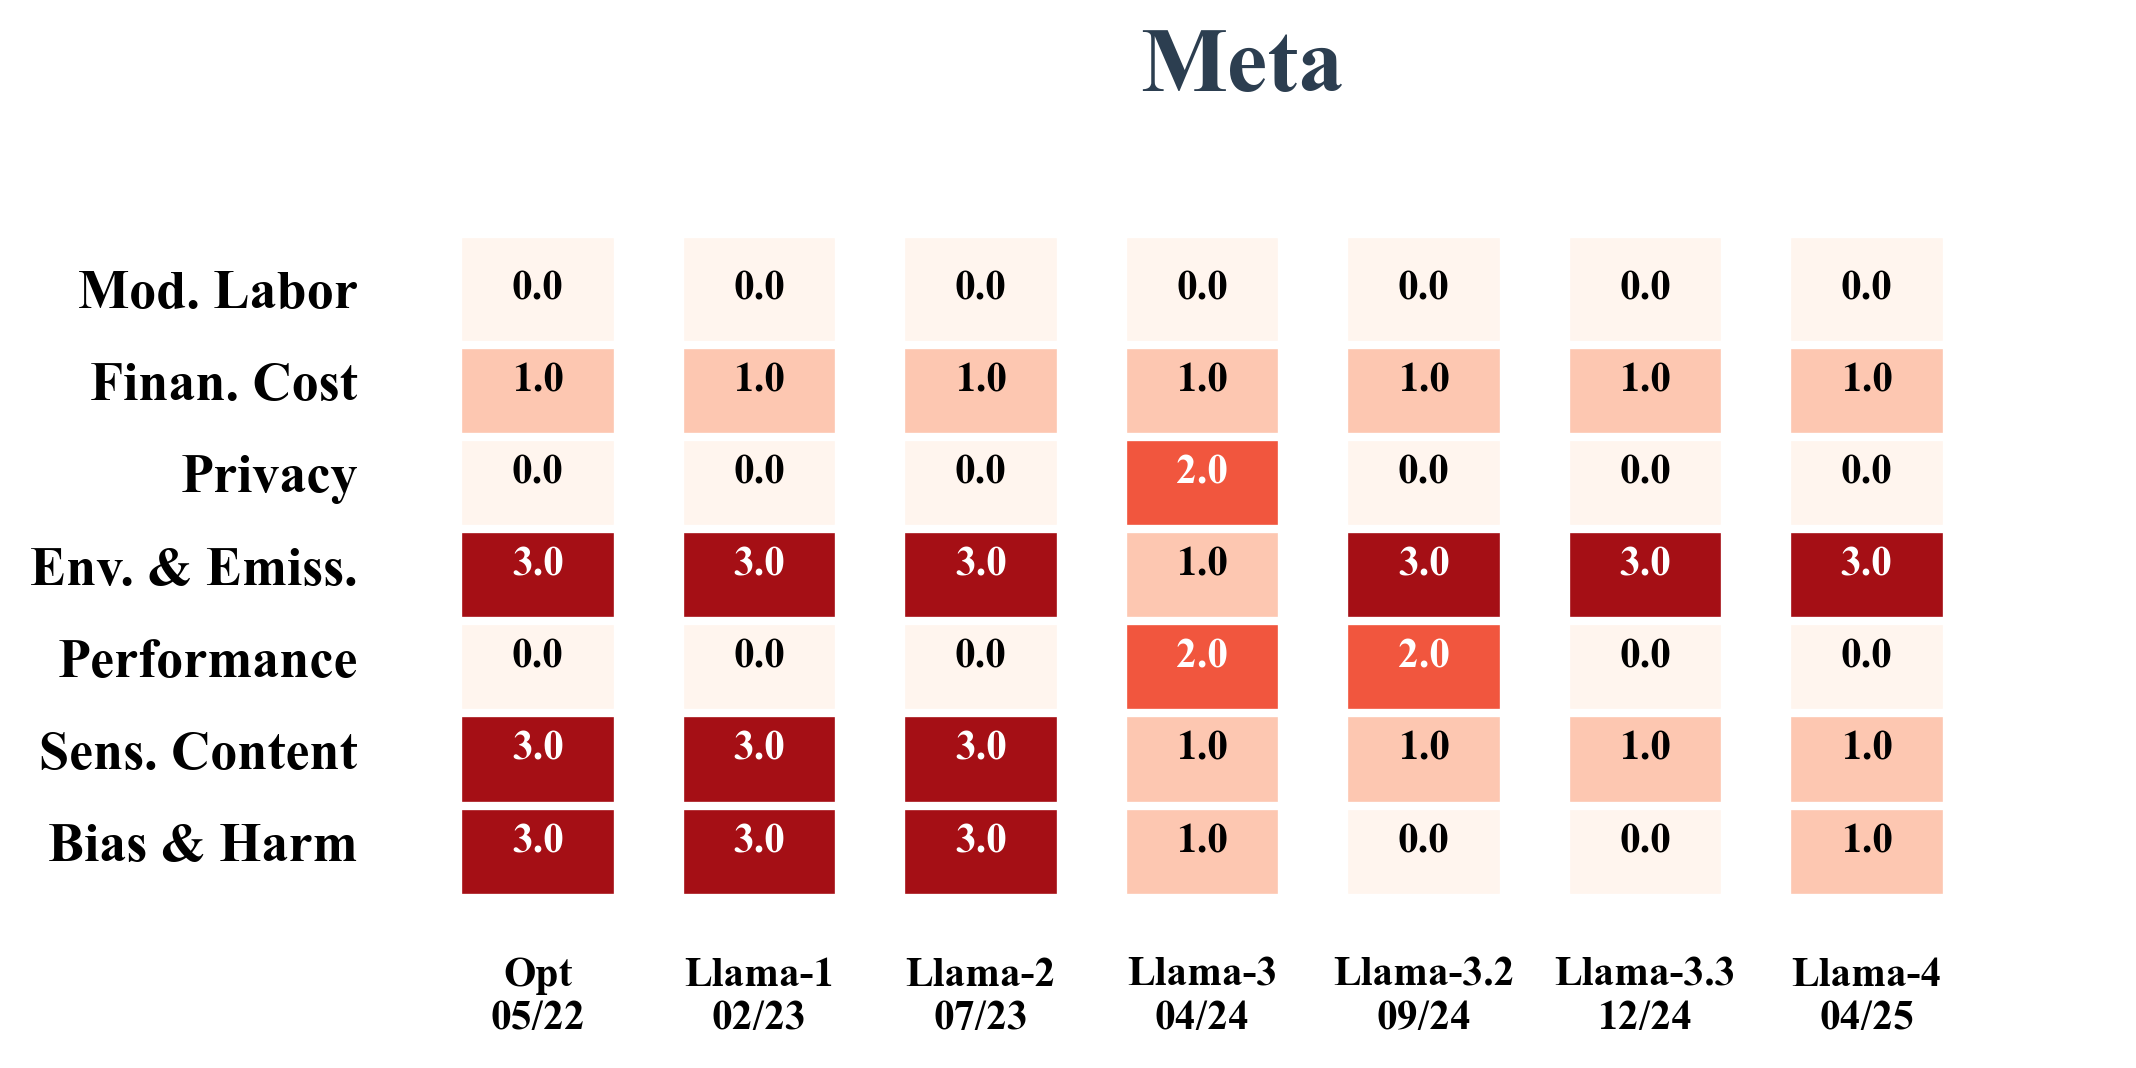

In [ ]:
fig, ax = plot_provider_reporting_quality('meta', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('meta_1p_overtime_adjusted.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

def plot_provider_reporting_quality(provider_name, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(10, 8), show_time_gaps=False, show_values=False, show_colorbar=True):
    """
    Generate a reporting quality heatmap for a single provider.

    Parameters:
    -----------
    provider_name : str
        Name of the provider to plot (e.g., 'openAi', 'meta', 'google', 'anthropic', 'mistral')
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # --- Provider Name Mapping for Proper Capitalization ---
    provider_name_mapping = {
        'openai': 'OpenAI',
        'meta': 'Meta',
        'google': 'Google',
        'anthropic': 'Anthropic',
        'mistral': 'Mistral'
    }

    # --- Font Setup ---
    # Download and register Times New Roman (regular, bold, and italic)
    font_files_to_download = {
        'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
        'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
        'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
    }

    # Create a directory for fonts if it doesn't exist
    font_dir = '/content/fonts'
    os.makedirs(font_dir, exist_ok=True)

    for fname, url in font_files_to_download.items():
        font_path = os.path.join(font_dir, fname)
        if not os.path.exists(font_path):
            subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

    # Register fonts with matplotlib
    for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
        fm.fontManager.addfont(font_path)

    # --- Matplotlib Style Configuration ---
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "font.size": 12,
        "axes.titlesize": 22, "axes.labelsize": 16, "xtick.labelsize": 12,
        "ytick.labelsize": 12, "legend.fontsize": 16,
        "axes.spines.top": False, "axes.spines.left": False,
        "axes.spines.right": False, "axes.spines.bottom": False,
        "axes.titlepad": 20, "font.family": "Times New Roman",
        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",
    })

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping with shortened labels
    category_mapping = {
        1: "Bias & Harm", 2: "Sens. Content", 3: "Performance",
        4: "Env. & Emiss.", 5: "Privacy", 6: "Finan. Cost",
        7: "Mod. Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Custom colormap from the first script
    colors_first = ['#FFF5EE', '#FEE0D2', '#FCBBA1', '#FB6A4A', '#DE2D26', '#A50F15']
    cmap = LinearSegmentedColormap.from_list('orange_red_gradient', colors_first, N=256)

    # Create figure with better spacing
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    all_categories = list(category_mapping.values())

    # Filter data for the specified provider
    curr_df = df[df.provider == provider_name].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)

        # Use proper capitalization for title
        display_name = provider_name_mapping.get(provider_name.lower(), provider_name.capitalize())
        ax.set_title(f'{display_name}', fontsize=22, fontweight='bold', pad=30)
        return fig, ax

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        formatted_name = row['name'].capitalize()
        model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Improved spacing calculation
    STANDARD_WIDTH = 12  # Increased for better spacing
    if len(model_names) == 1:
        model_positions = [STANDARD_WIDTH / 2]
    else:
        # Add more padding between models
        model_positions = np.linspace(1, STANDARD_WIDTH - 1, len(model_names))

    # Create complete combinations for all categories and models
    complete_df = pd.DataFrame([
        {'name': model, 'category': category}
        for model in model_names
        for category in all_categories
    ])

    # Merge with actual data and fill missing scores with 0
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    ).fillna({'score': 0})

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category', columns='name', values='score', aggfunc='mean'
    ).reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using rectangles with larger cells for better space filling
    cell_width = 1.2  # Increased cell size to fill more space
    cell_height = 1.2

    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)

            rect = plt.Rectangle(
                (model_positions[j] - cell_width/2, i - cell_height/2),
                cell_width, cell_height,
                facecolor=color, edgecolor='white', linewidth=2
            )
            ax.add_patch(rect)

            if show_values:
                text_color = 'white' if score > 1.5 else 'black'
                ax.text(model_positions[j], i, f'{score:.1f}',
                       ha='center', va='center', fontsize=10,
                       fontweight='bold', color=text_color)

    # --- Axis and Label Formatting with Improved Spacing ---
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=12, fontweight='bold')

    ax.set_yticks(range(len(all_categories)))
    # No need for text wrapping with shorter labels
    ax.set_yticklabels(all_categories, fontsize=13, fontweight='bold')

    ax.tick_params(axis='x', which='both', length=0, pad=10)  # Added padding
    ax.tick_params(axis='y', which='both', length=0, pad=5)   # Reduced padding to remove whitespace

    # Add time gap indicators if requested
    if show_time_gaps and len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                ax.axvline(x=gap_x, color='#bdc3c7', linewidth=1.5, linestyle=':')

    # Set axis limits with minimal left margin to reduce whitespace
    ax.set_xlim(-0.2, STANDARD_WIDTH + 0.8)
    ax.set_ylim(-0.8, len(all_categories) - 0.2)
    ax.grid(False)

    # Add colorbar if requested with improved positioning
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20, pad=0.05)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=25, fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=11)
        cbar.outline.set_visible(False)

    # Title with proper capitalization
    display_name = provider_name_mapping.get(provider_name.lower(), provider_name.capitalize())
    ax.set_title(f'{display_name}', fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

    # Improved layout with better margins
    plt.tight_layout(rect=[0.02, 0.02, 0.93, 0.95])

    return fig, ax

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

def plot_provider_reporting_quality(provider_name, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(10, 8), show_time_gaps=False, show_values=False, show_colorbar=True):
    """
    Generate a reporting quality heatmap for a single provider.

    Parameters:
    -----------
    provider_name : str
        Name of the provider to plot (e.g., 'openAi', 'meta', 'google', 'anthropic', 'mistral')
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # --- Provider Name Mapping for Proper Capitalization ---
    provider_name_mapping = {
        'openai': 'OpenAI',
        'meta': 'Meta',
        'google': 'Google',
        'anthropic': 'Anthropic',
        'mistral': 'Mistral'
    }

    # --- Font Setup ---
    # Download and register Times New Roman (regular, bold, and italic)
    font_files_to_download = {
        'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
        'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
        'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
    }

    # Create a directory for fonts if it doesn't exist
    font_dir = '/content/fonts'
    os.makedirs(font_dir, exist_ok=True)

    for fname, url in font_files_to_download.items():
        font_path = os.path.join(font_dir, fname)
        if not os.path.exists(font_path):
            subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

    # Register fonts with matplotlib
    for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
        fm.fontManager.addfont(font_path)

    # --- Matplotlib Style Configuration ---
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "font.size": 12,
        "axes.titlesize": 22, "axes.labelsize": 16, "xtick.labelsize": 12,
        "ytick.labelsize": 12, "legend.fontsize": 16,
        "axes.spines.top": False, "axes.spines.left": False,
        "axes.spines.right": False, "axes.spines.bottom": False,
        "axes.titlepad": 20, "font.family": "Times New Roman",
        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",
    })

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping with shortened labels
    category_mapping = {
        1: "Bias & Harm", 2: "Sens. Content", 3: "Performance",
        4: "Env. & Emiss.", 5: "Privacy", 6: "Finan. Cost",
        7: "Mod. Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Custom colormap from the first script
    colors_first = ['#FFF5EE', '#FEE0D2', '#FCBBA1', '#FB6A4A', '#DE2D26', '#A50F15']
    cmap = LinearSegmentedColormap.from_list('orange_red_gradient', colors_first, N=256)

    # Create figure with better spacing
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    all_categories = list(category_mapping.values())

    # Filter data for the specified provider
    curr_df = df[df.provider == provider_name].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)

        # Use proper capitalization for title
        display_name = provider_name_mapping.get(provider_name.lower(), provider_name.capitalize())
        ax.set_title(f'{display_name}', fontsize=22, fontweight='bold', pad=30)
        return fig, ax

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        formatted_name = row['name'].capitalize()
        model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Improved spacing calculation
    STANDARD_WIDTH = 12  # Increased for better spacing
    if len(model_names) == 1:
        model_positions = [STANDARD_WIDTH / 2]
    else:
        # Add more padding between models
        model_positions = np.linspace(1, STANDARD_WIDTH - 1, len(model_names))

    # Create complete combinations for all categories and models
    complete_df = pd.DataFrame([
        {'name': model, 'category': category}
        for model in model_names
        for category in all_categories
    ])

    # Merge with actual data and fill missing scores with 0
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    ).fillna({'score': 0})

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category', columns='name', values='score', aggfunc='mean'
    ).reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using rectangles with larger cells for better space filling
    cell_width = 1.2  # Increased cell size to fill more space
    cell_height = 1.2

    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)

            rect = plt.Rectangle(
                (model_positions[j] - cell_width/2, i - cell_height/2),
                cell_width, cell_height,
                facecolor=color, edgecolor='white', linewidth=2
            )
            ax.add_patch(rect)

            if show_values:
                text_color = 'white' if score > 1.5 else 'black'
                ax.text(model_positions[j], i, f'{score:.1f}',
                       ha='center', va='center', fontsize=10,
                       fontweight='bold', color=text_color)

    # --- Axis and Label Formatting with Improved Spacing ---
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=0, ha='center', fontsize=10, fontweight='bold')

    ax.set_yticks(range(len(all_categories)))
    # No need for text wrapping with shorter labels
    ax.set_yticklabels(all_categories, fontsize=13, fontweight='bold')

    ax.tick_params(axis='x', which='both', length=0, pad=10)  # Added padding
    ax.tick_params(axis='y', which='both', length=0, pad=5)   # Reduced padding to remove whitespace

    # Add time gap indicators if requested
    if show_time_gaps and len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                ax.axvline(x=gap_x, color='#bdc3c7', linewidth=1.5, linestyle=':')

    # Set axis limits with minimal left margin to reduce whitespace
    ax.set_xlim(-0.2, STANDARD_WIDTH + 0.8)
    ax.set_ylim(-0.8, len(all_categories) - 0.2)
    ax.grid(False)

    # Add colorbar if requested with improved positioning
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20, pad=0.05)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=25, fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=11)
        cbar.outline.set_visible(False)

    # Title with proper capitalization
    display_name = provider_name_mapping.get(provider_name.lower(), provider_name.capitalize())
    ax.set_title(f'{display_name}', fontsize=22, fontweight='bold', pad=30, color='#2c3e50')

    # Improved layout with better margins
    plt.tight_layout(rect=[0.02, 0.02, 0.93, 0.95])

    return fig, ax